# Visualization of the content of a layer in a CNN

Given a pretrained neural network and an input image, this technique generates a new image that fits the representation of the by a given layer of the network. 
This image generation method is the basis of neural style transfer.

Following [this paper](https://arxiv.org/pdf/1412.0035.pdf).First, we pass the input image through the network up to a given layer.

In [1]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from im_func import show_image
import numpy as np
import matplotlib.pyplot as plt

# Get images

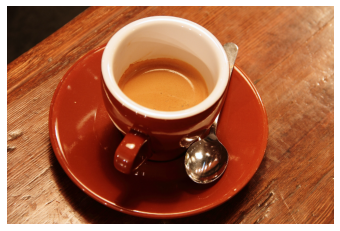

In [2]:
im = skimage.data.coffee()
_ = show_image(im)

# Pre/post processing of image

Normalization, resizing etc... to correspond to the input format of images trained by t

In [3]:
# From D2L
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
#     img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [4]:
# Apply pre-proc to imagae
im_shape = (150, 225)
im_new = preprocess(im,im_shape)
im_new

tensor([[[[-1.7583, -1.7583, -1.7412,  ...,  1.6495,  1.7523,  1.8037],
          [-1.7583, -1.7583, -1.7412,  ...,  1.5810,  1.7180,  1.7865],
          [-1.7754, -1.7754, -1.7412,  ...,  1.6495,  1.6495,  1.6838],
          ...,
          [ 1.0673,  1.1700,  1.3242,  ...,  0.3138,  0.2453,  0.5878],
          [ 1.0844,  1.2728,  1.2385,  ...,  0.1254,  0.5022,  0.5364],
          [ 1.2899,  1.2385,  1.2899,  ...,  0.4166,  0.6392,  0.4679]],

         [[-1.8081, -1.7906, -1.7731,  ...,  1.0105,  1.0805,  1.1681],
          [-1.8081, -1.8081, -1.7906,  ...,  0.9405,  1.0455,  1.1681],
          [-1.8256, -1.8256, -1.7906,  ...,  1.0630,  1.0280,  1.0280],
          ...,
          [ 0.2752,  0.2927,  0.5378,  ..., -0.9853, -0.9328, -0.7052],
          [ 0.1702,  0.4153,  0.4678,  ..., -0.9853, -0.7577, -0.7577],
          [ 0.4328,  0.4328,  0.4853,  ..., -0.7577, -0.7052, -0.8102]],

         [[-1.6476, -1.6476, -1.6476,  ...,  0.4788,  0.5311,  0.6008],
          [-1.6824, -1.6650, -

# Get a pretrained model

In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [6]:
pretrained_net.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [7]:
class ImageGenerator(nn.Module):
    def __init__(self,shape):
        super(ImageGenerator,self).__init__()
        self.im = nn.Parameter(torch.rand(1, 3, *shape))
    def forward(self):
        return self.im

In [8]:
# Apply layer by layer mods
def partial_forward(input_im,n_layer):
    X = input_im
    for il in range(n_layer):
        X = pretrained_net.features[il](X)
    return X

def visu_im_rep(X, ncol=5):
    nrow = int(np.ceil(n_channels/ncol))
    fig, ax = plt.subplots(nrow,ncol,figsize=[15,24],tight_layout=True)
    with torch.no_grad():
        for ic in range(n_channels):
            plt.sca(ax[np.unravel_index(ic,(nrow,ncol))])
            show_image(X[0,ic,:,:])

`x` is the representation of our input image by the given layer. This representation is composed of many channels, each the result of a specific convolution that has been optimized through training to extract specific useful features. 
Now, we instantiate the simple ImageGenerator. `im_gen` parameters' (`list(im_gen.parameters())[0]`) contains a tensor initialized with random noise. 

In [9]:
len(pretrained_net.features)

37

In [10]:
im_gen = ImageGenerator(im_shape)
current_im = list(im_gen.parameters())[0]
# preprocess(current_im,im_shape).shape
layer = 5

target_rep = partial_forward(preprocess(im,im_shape), layer)


loss_fn = nn.MSELoss()
# optim = torch.optim.Adam(im_gen.parameters())
optim = torch.optim.LBFGS(im_gen.parameters())
# im_rep.shape
# visu_im_rep(target_rep)

In [11]:
# train
def closure():
#     if torch.is_grad_enabled():
    optim.zero_grad()
    im_rep = partial_forward(im_gen(), layer)
    loss = loss_fn(im_rep,target_rep.detach())
    loss.backward()
    return loss


for i in range(1000):    
    optim.step(closure)
    if i%1==0:
        with torch.no_grad():
            im_rep = partial_forward(im_gen(), layer)
            loss = loss_fn(im_rep,target_rep.detach())
            print(f"epoch {i:02d}, loss: {loss:.10e}")
            if loss<1e-1:
                break

epoch 00, loss: 3.4194439650e-01
epoch 01, loss: 1.4755702019e-01
epoch 02, loss: 9.1823220253e-02


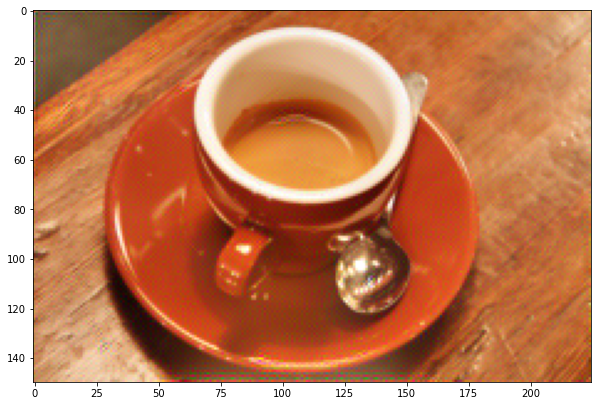

In [12]:
current_im = list(im_gen.parameters())[0][0]
fig, ax = plt.subplots(1,1,figsize=[10,10])
imnew = postprocess(current_im)
plt.imshow(imnew)